# Document Scanner

Implementation of a document scanner using Python an OpenCV

## Utility functions
Let's implement a few functions that we will use later.

In [7]:
import numpy as np
import cv2
from skimage.filters import threshold_local
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

1. Euclidean distance: straight line distance between two points in a Euclidean plane.

In [2]:
def euclidean_distance(a,b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) **2)

2. Function to sort vertices in a clockwise order

In [15]:
def sort_vertices(pts):
    # Initialize a list of ordered co-ordinates (clockwise)
    vertices = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    # Top Left- Smallest Sum
    vertices[0] = pts[np.argmin(s)]
    # Bottom Right- Largest Sum
    vertices[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top Right- Smallest Difference
    vertices[1] = pts[np.argmin(diff)]
    # Bottom Left- Largest Difference
    vertices[3] = pts[np.argmax(diff)]

    # Return the clockwise ordered coordinates
    return vertices

3. Function for rectangular perspectice transformation

In [4]:
def four_point_perspective_transform(image, pts):
    """
    Takes four points and generates a rectangular perspective
    transformation to get a top-down view of the image
    """
    # Order the points
    rect = sort_vertices(pts)
    (tl, tr, br, bl) = rect

    # Estimate the width of the new image
    # Max of width of top and bottom co-ordinates
    widthA = euclidean_distance(br, bl)
    widthB = euclidean_distance(tr, tl)
    maxWidth = max(int(widthA), int(widthB))

    # Estimate the height of the new image
    # Max of the height of left and right coordinates
    heightA = euclidean_distance(tr, br)
    heightB = euclidean_distance(tl, bl)
    maxHeight = max(int(heightA), int(heightB))

    # Estimate the destination points using the calculated dimensions
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Return the warped image
    return warped

4. Function to display images side-by-side

In [8]:
def display_sbs(imgLr, imgRr):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.rot90(imgLr,0))
    f.add_subplot(1,2, 2)
    plt.imshow(np.rot90(imgRr,0))
    plt.show(block=True)

## Main program

### Step 1: Reading the image and converting it into grayscale

Reading image

In [9]:
image = cv2.imread("images/receipt.jpg")

In [10]:
image_copy = image.copy()
image = cv2.resize(image, (1500, 800))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
image_edge = cv2.Canny(image_gray, 75, 200)

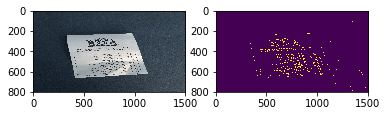

In [11]:
display_sbs(image, image_edge)

### Step 2: find contours on the image

In [12]:
cnts, hiers = cv2.findContours(image_edge.copy(), cv2.RETR_LIST,
                        cv2.CHAIN_APPROX_SIMPLE)[-2:]
# cnts = cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(approx) == 4:
        screenCnt = approx
        breakcnts = cv2.findContours(image_edge.copy(), cv2.RETR_LIST,
                                     cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(approx) == 4:
        screenCnt = approx
        breakcnts

### Step 3: draw contours on the image 

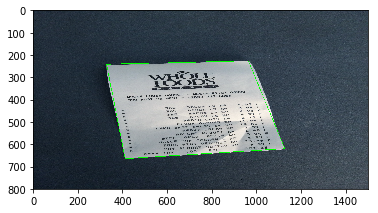

In [13]:
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(np.rot90(image,0))
plt.show(block=True)

### Step 4: warp this image to display only the receipt

In [19]:
warped_image = four_point_perspective_transform(image, screenCnt.reshape(4,2))

In [20]:
warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped_image, 11, offset=10, method="gaussian")
warped_image = (warped_image > T).astype("uint8") * 255

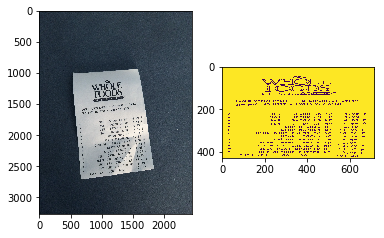

In [21]:
display_sbs(image_copy, warped_image)

Finally, save this image.

In [22]:
cv2.imwrite('./images/scanned.png', warped_image)
print("Image scanned and saved")

Image scanned and saved
